In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.openpose import OpenposeDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

/home/jimgoo/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [3]:
apply_openpose = OpenposeDetector()

model = create_model("./models/cldm_v15.yaml").cpu()
model.load_state_dict(
    load_state_dict("./models/control_sd15_openpose.pth", location="cuda")
)
model = model.cuda()
ddim_sampler = DDIMSampler(model)

#
# Load embedding
#
model.cond_stage_model.load_textual_inversion_embeddings(
    [
        "ti_embeddings/neon.pt",
        "ti_embeddings/CharTurner.pt",
    ],
    allow_replacement=False,
)


cuda
cuda
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
tokenizer PreTrainedTokenizer(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_len=77, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_openpose.pth]


In [5]:
from PIL import Image

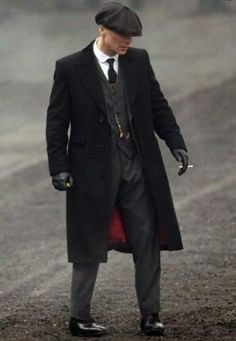

In [7]:
input_image = Image.open('test_imgs/pose2.png')
input_image

In [24]:
prompt = 'An astronaut on the moon'
num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
detect_resolution = 512
ddim_steps = 20
scale = 9.0
seed = 42
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

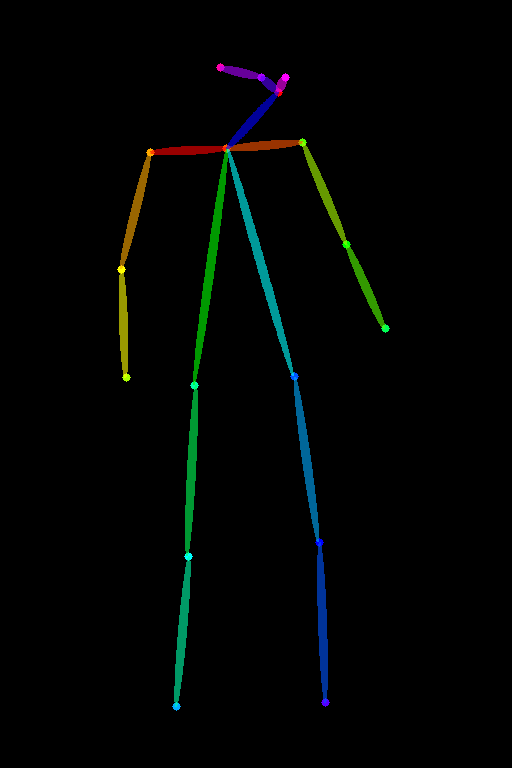

In [22]:
with torch.no_grad():
    input_image = HWC3(np.array(input_image))
    detected_map, _ = apply_openpose(resize_image(input_image, detect_resolution))
    detected_map = HWC3(detected_map)
    img = resize_image(input_image, image_resolution)
    H, W, C = img.shape

    detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

Image.fromarray(detected_map)

In [39]:
prompt = ['an astronaut on']*20
prompt = ' '.join(prompt)  + ', the moon'
prompt

'an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on, the moon'

In [40]:
with torch.no_grad():
#     input_image = HWC3(np.array(input_image))
#     detected_map, _ = apply_openpose(resize_image(input_image, detect_resolution))
#     detected_map = HWC3(detected_map)
#     img = resize_image(input_image, image_resolution)
#     H, W, C = img.shape

#     detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

    control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, "b h w c -> b c h w").clone()

    if seed == -1:
        seed = random.randint(0, 65535)
    seed_everything(seed)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    cond = {
        "c_concat": [control],
        "c_crossattn": [
            model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
        ],
    }
    un_cond = {
        "c_concat": None if guess_mode else [control],
        "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
    }
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = (
        [strength * (0.825 ** float(12 - i)) for i in range(13)]
        if guess_mode
        else ([strength] * 13)
    )
    samples, intermediates = ddim_sampler.sample(
        ddim_steps,
        num_samples,
        shape,
        cond,
        verbose=False,
        eta=eta,
        unconditional_guidance_scale=scale,
        unconditional_conditioning=un_cond,
    )

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (
        (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
        .cpu()
        .numpy()
        .clip(0, 255)
        .astype(np.uint8)
    )

    results = [x_samples[i] for i in range(num_samples)]


Global seed set to 42


get_learned_conditioning for c= ['an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on, the moon, best quality, extremely detailed']
using encode
text ['an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on an astronaut on, the moon, best quality, extremely detailed']
batch_encoding {'overflowing_tokens': tensor([], size=(1, 0)), 'num_truncated_tokens': tensor([-6]), 'input_ids': tensor([[49406,   550, 18376,   525,   550, 18376,   525,   550, 18376,   525,
           550, 18376

DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.49it/s]


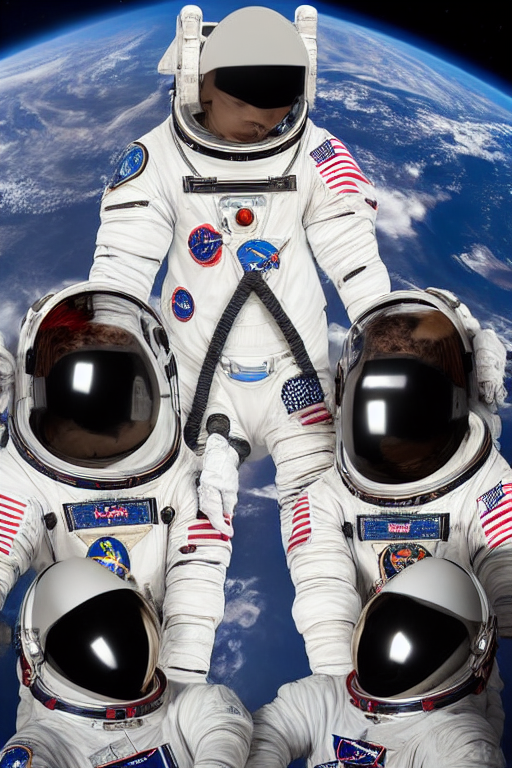

In [42]:
Image.fromarray(x_samples[0])